In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from gee_scripts.randomforest import get_regressor

# 1. Read training data

In [3]:
# read phu regions shapefile
phu_regions = gpd.read_file("data/0_shp/AOI__Province__865_PHUs__INDONESIA.gpkg")
phu_regions = phu_regions.to_crs("EPSG:4326")

In [4]:
df = pd.read_csv("data/9_clean_training_data/clean_training_data.csv")

# Convert to GeoDataFrame
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
# do spatial join with phu's
df = gpd.sjoin(df, phu_regions, how="left", predicate="within")

In [5]:
# Get the number of cases per PHU
phu_cases = df.groupby("phu_id").size().reset_index(name="observations")

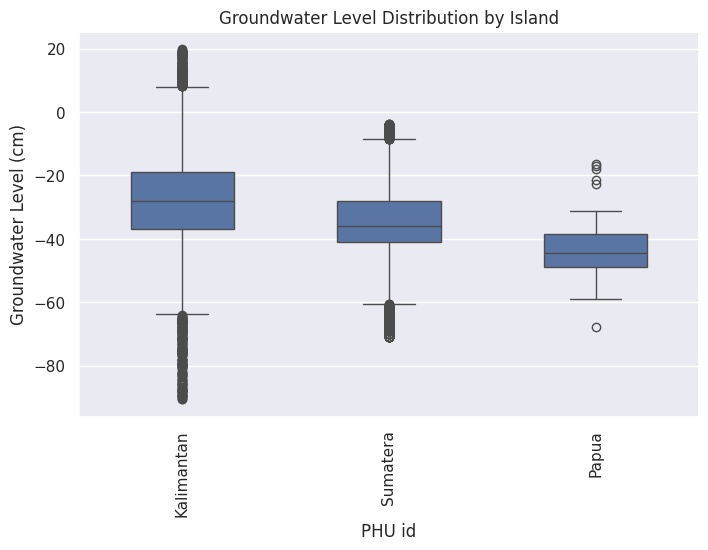

In [6]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="island", y="gwl_cm", data=df, width=0.5)

# Rename x-axis with phu id
plt.xticks(rotation=90)
plt.xlabel("PHU id")
plt.ylabel("Groundwater Level (cm)")
plt.title("Groundwater Level Distribution by Island")
plt.show()

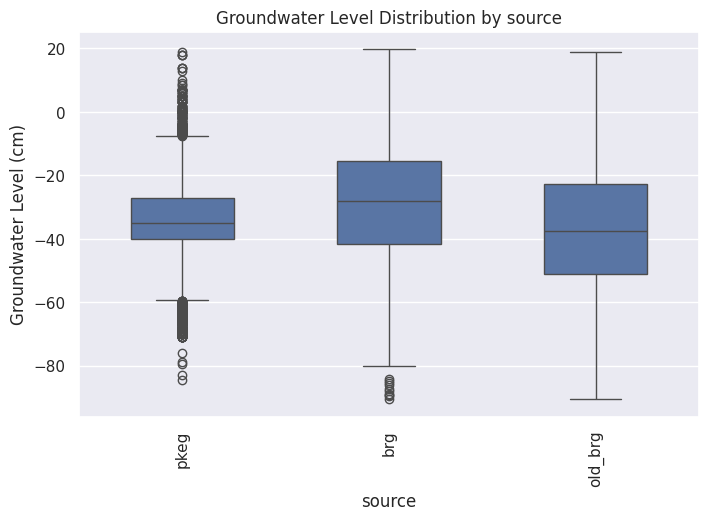

In [7]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="source", y="gwl_cm", data=df, width=0.5)

# Rename x-axis with phu id
plt.xticks(rotation=90)
plt.xlabel("source")
plt.ylabel("Groundwater Level (cm)")
plt.title("Groundwater Level Distribution by source")
plt.show()

Text(0.5, 1.0, 'Groundwater Level Distribution by Province')

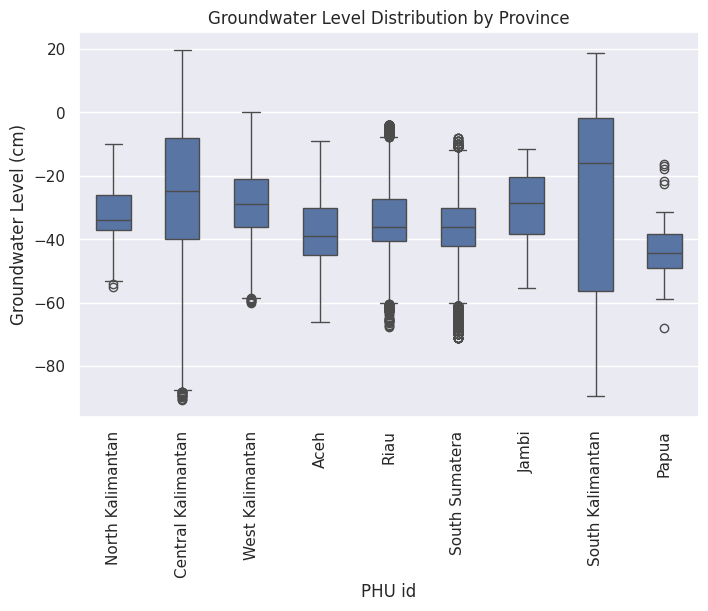

In [8]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="province", y="gwl_cm", data=df, width=0.5)

# Rename x-axis with phu id
plt.xticks(rotation=90)
plt.xlabel("PHU id")
plt.ylabel("Groundwater Level (cm)")
plt.title("Groundwater Level Distribution by Province")

## Create a boxplot showing the number of dates per each point

In [9]:
df.columns

Index(['source', 'id', 'date', 'gwl_cm', 'lat', 'lon', 'LIA', 'VH', 'VV',
       'VVVH_ratio', 'angle', 'sm_1', 'sm_3', 'sm_7', 'sm_30', 'precipitation',
       'prec_3', 'prec_7', 'prec_30', 'elevation', 'aspect', 'slope',
       'land_cov', 'canopy_height', 'gldas_mean', 'gldas_stddev', 'B3', 'B4',
       'B5', 'B7', 'ndvi', 'ndmi', 'ndbri', 'doy', 'region_id', 'percentile',
       'geometry', 'index_right', 'island', 'province', 'phu_name', 'aoi_phu',
       'tile_id', 'phu_id'],
      dtype='object')

In [10]:
# group by id and get the number of dates for each id
group_by = "id"
df_grouped = df.groupby(group_by).count().reset_index()
df_grouped = df_grouped[[group_by, "date"]]
df_grouped.columns = ["name", "date_count"]
df_grouped.sort_values(by="date_count", ascending=False)

,name,date_count
1941,BRG_140806_01,207
744,15_RAPP_PPDV-05a,206
1952,BRG_150710_03,191
778,15_RAPP_PPDVIII-23,173
981,15_RAPP_TP-IV-23,170
...,...,...
892,15_RAPP_SKM/XII-13,1
1284,199_GAL_F55,1
893,15_RAPP_SKM/XII-14a,1
894,15_RAPP_SKM/XII-15a,1


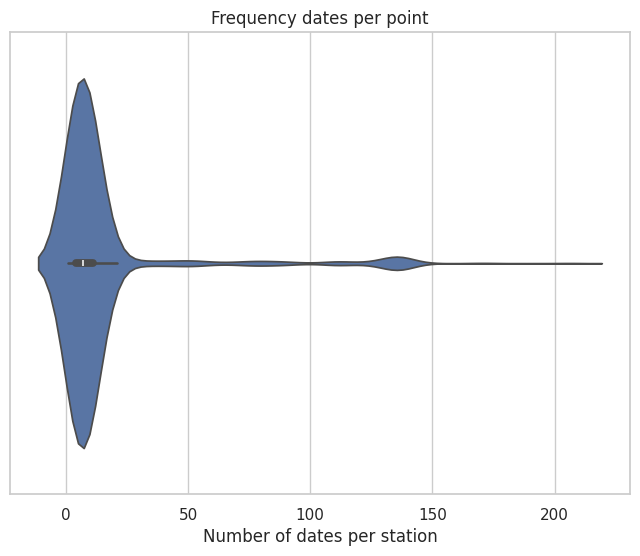

In [11]:
# Define the dimensions of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create a violin plot for the variable
sns.violinplot(x=df_grouped["date_count"])

# Set the title and x-axis label
plt.title(f"Frequency dates per point")
plt.xlabel("Number of dates per station")

plt.show()

In [12]:
# drop all stations with less tan 9 observations
min_obs = 9
df.groupby('id').agg({'date': 'count'}).sort_values(by='date', ascending=False).reset_index()
df = df.groupby('id').filter(lambda group: len(group) >= min_obs)

In [13]:
from gee_scripts.parameters import explain_vars, response_var
print("dependent var", response_var)
print("explanatory lenght", len(explain_vars))

dependent var ['gwl_cm']
explanatory lenght 28


# 2. Define a model

## All but one test over stations

In [14]:
from gee_scripts.randomforest import run_randomforest
from gee_scripts.randomforest import get_heatmap

In [15]:
variable = 'gwl_cm'

high_corr_ids = pd.read_csv("data/high_corr_0.2_temporal_variables_station_ids.csv")
high_corr_ids.columns = ["id"]

training_df = df[
    (df.island == "Kalimantan") &
    (df.id.isin(high_corr_ids.id.unique()))
]

# Manually selected PHU for training
# high_corr_phu_ids = [
#     136,
#     137,
#     138,
#     143
# ]
# training_df = df[
#     (df.phu_id.isin(high_corr_phu_ids))
# ]

stats_df = run_randomforest(training_df, type_="allbutone")

total points: 1718
total stations: 56
Starting random forest model...


0it [00:00, ?it/s]

56it [02:37,  2.81s/it]


<Axes: >

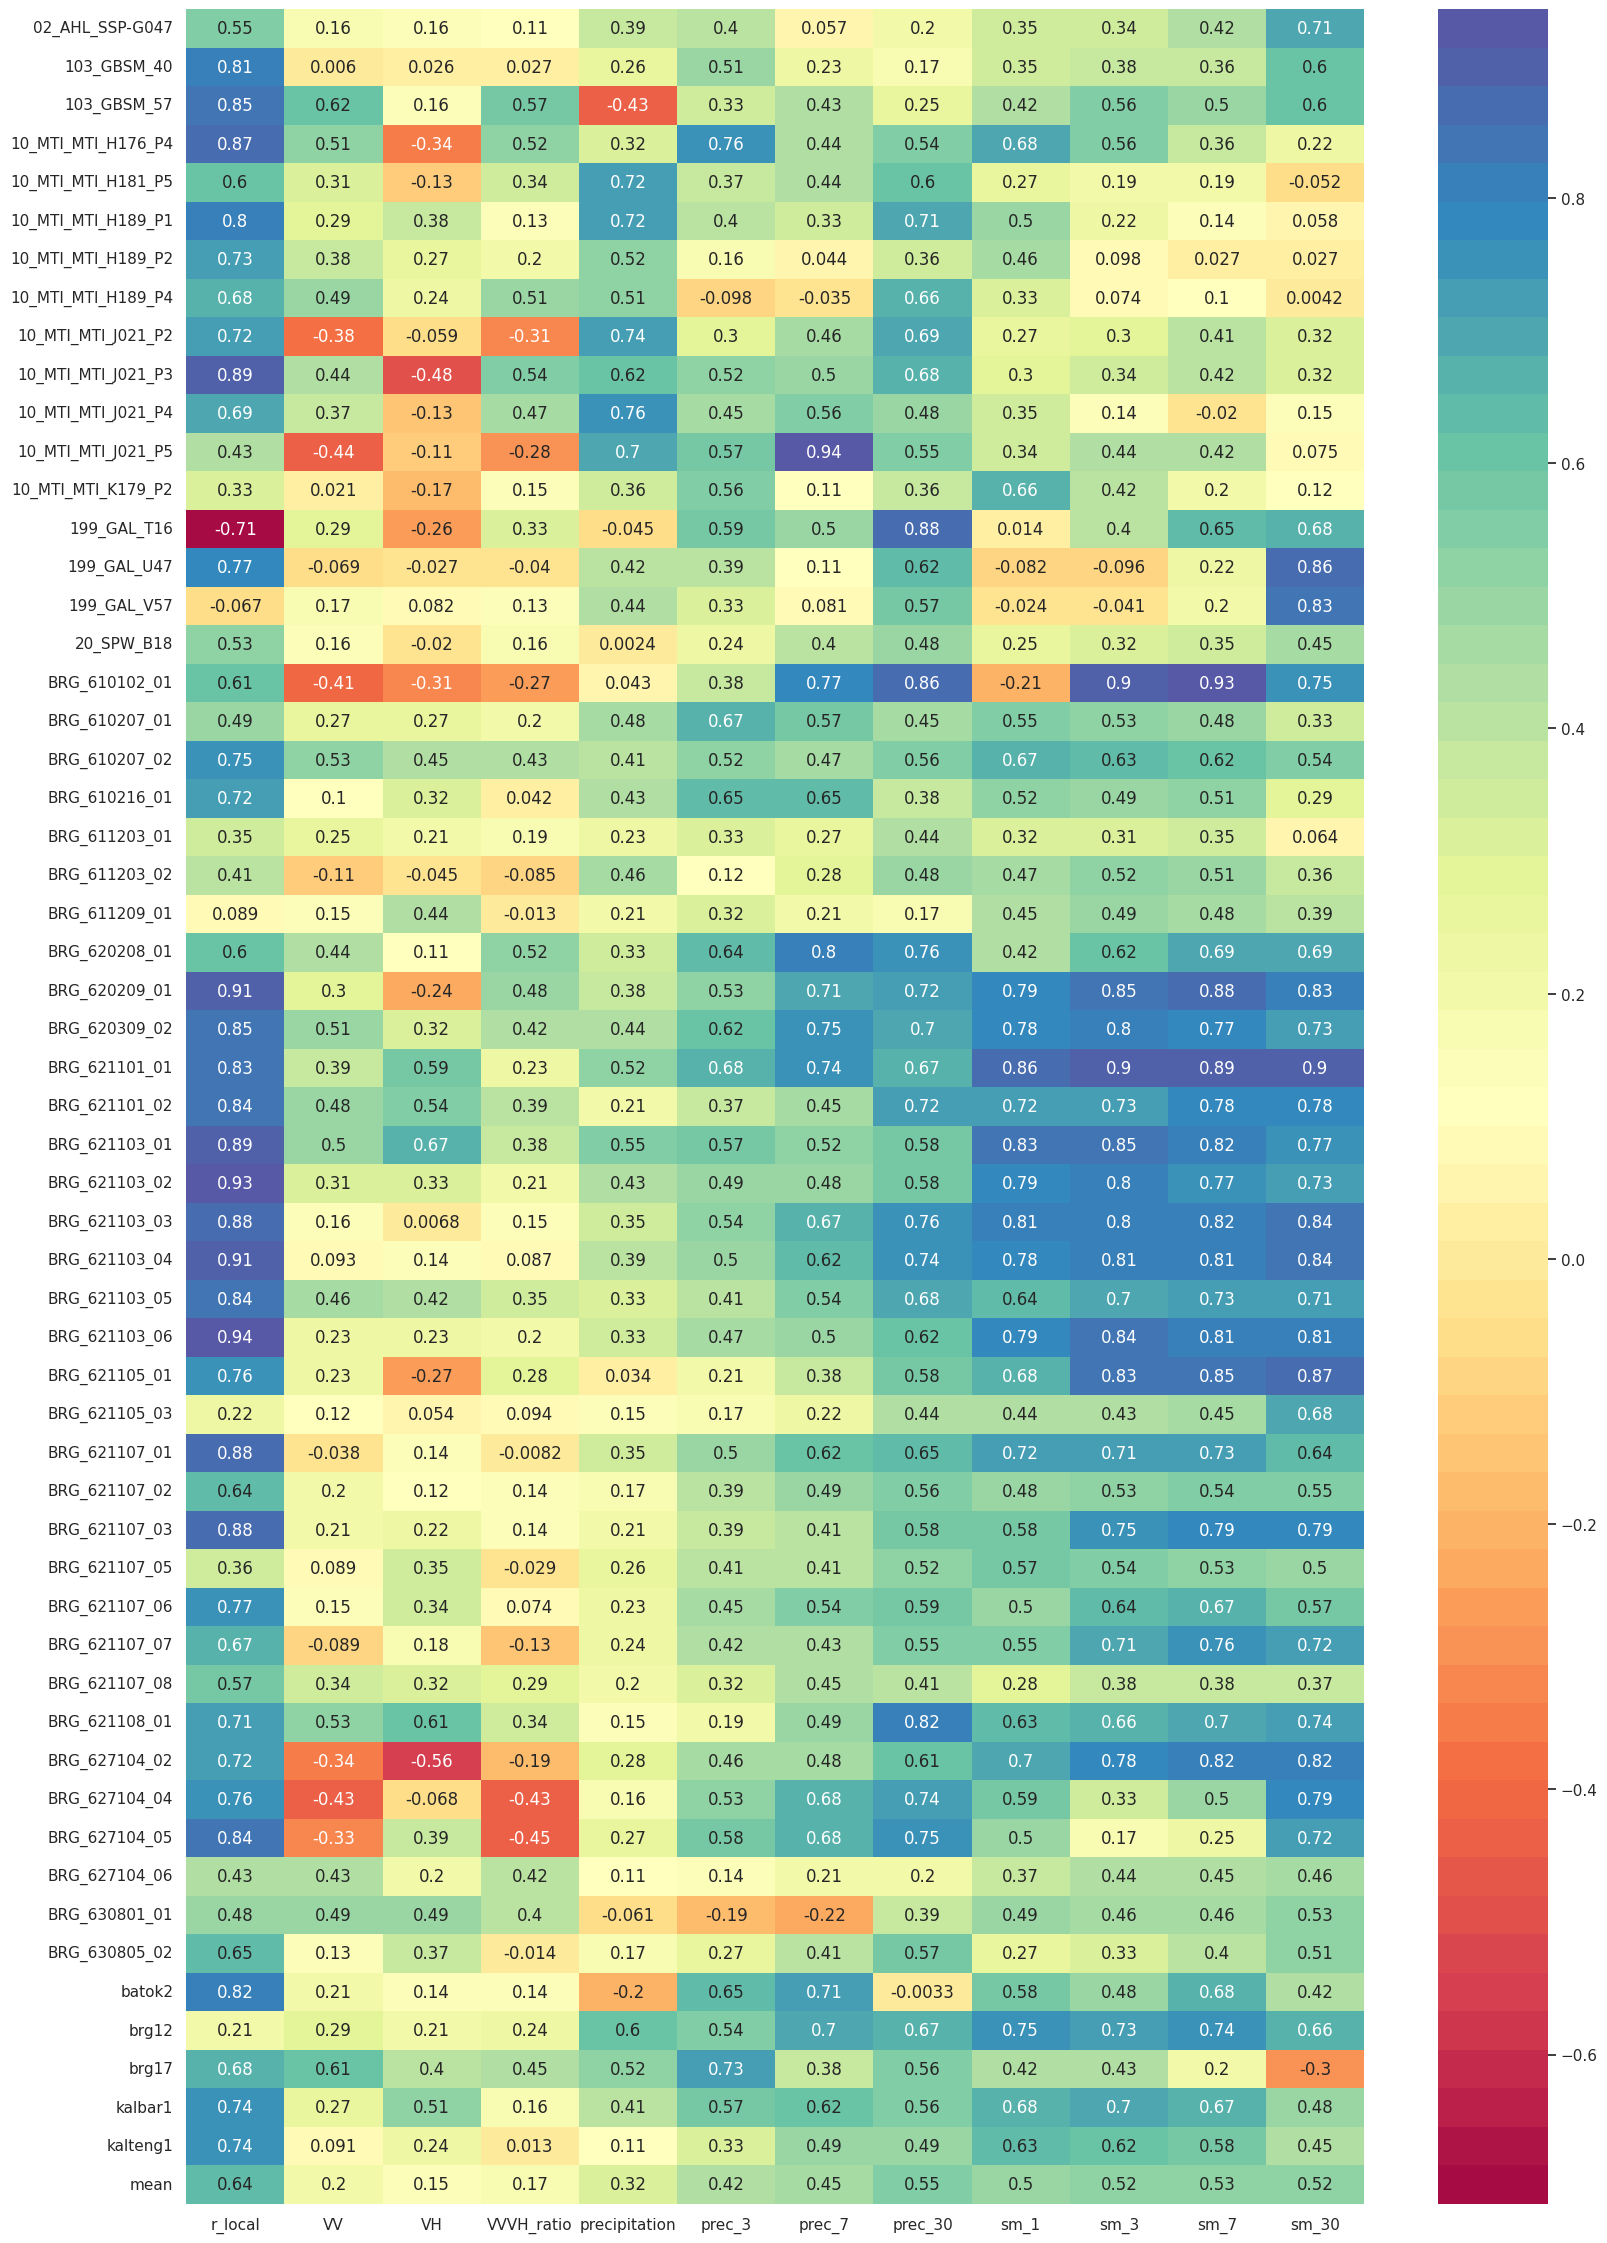

In [16]:
get_heatmap(stats_df, "r_local")

<Axes: title={'center': 'RMSE of stations'}>

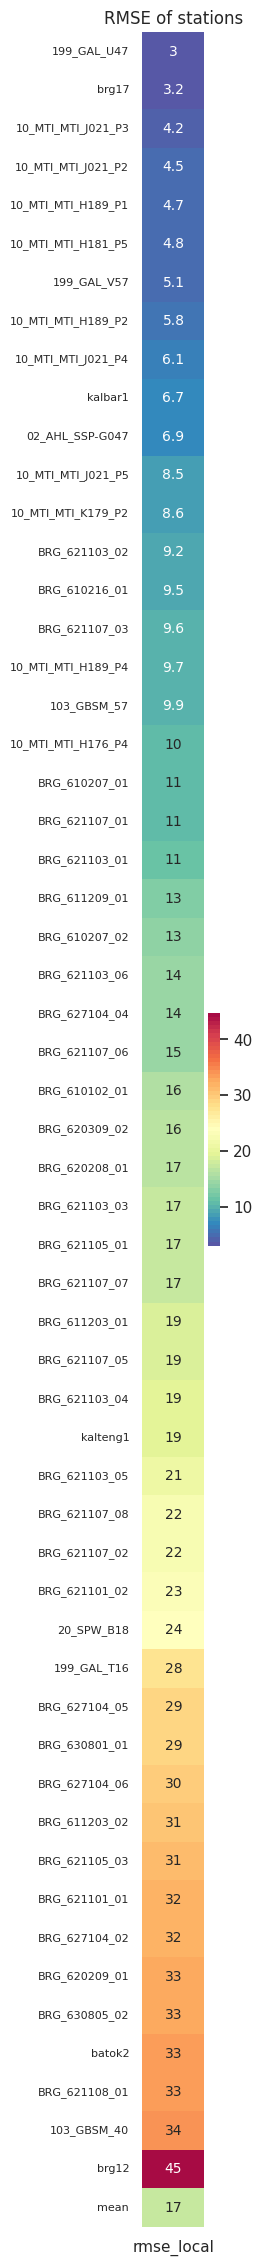

In [17]:
get_heatmap(stats_df, "rmse_local")

## Select best stations

In [18]:
stats_df.columns

Index(['r_local', 'rmse_local', 'VV', 'VH', 'VVVH_ratio', 'precipitation',
       'prec_3', 'prec_7', 'prec_30', 'sm_1', 'sm_3', 'sm_7', 'sm_30'],
      dtype='object')

In [19]:
best_stations = stats_df[stats_df.rmse_local < 15].sort_values(by="r_local", ascending=False).index
best_stations
len(best_stations)

27

## Model with best stations over all stations

In [20]:
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
from gee_scripts.parameters import explain_vars, temporal_expl

In [21]:
# split gdf into good statoins for train
gdf_high = training_df[training_df.id.isin(best_stations)].copy()
# and bad stations for test
gdf_low = training_df[~training_df.id.isin(best_stations)].copy()

variable = 'gwl_cm'

# create and train classifier
regr = get_regressor()
regr.fit(gdf_high[explain_vars], gdf_high[variable])

row = {}
#rmse_list = []
for station in gdf_low.id.unique():
    explans = []
    # apply model to specific station
    gdf_test = gdf_low[gdf_low.id == station]
    y_pred_test = regr.predict(gdf_test[explain_vars])

    # get pearsons r
    r, p = pearsonr(gdf_test[variable].values, y_pred_test)
    explans.append(r)

    explans.append(np.sqrt(mean_squared_error(gdf_test[variable].values, y_pred_test)))

    # add correlation of explanatories
    for expl in temporal_expl:
        explans.append(gdf_test[variable].corr(gdf_test[expl]))
     
    row[station] = explans
    #row[station] = [np.sqrt(mean_squared_error(gdf_test[variable].values, y_pred_test))]
    #print(row)
    
stats_df = pd.DataFrame.from_dict(row, orient='index')

<Axes: >

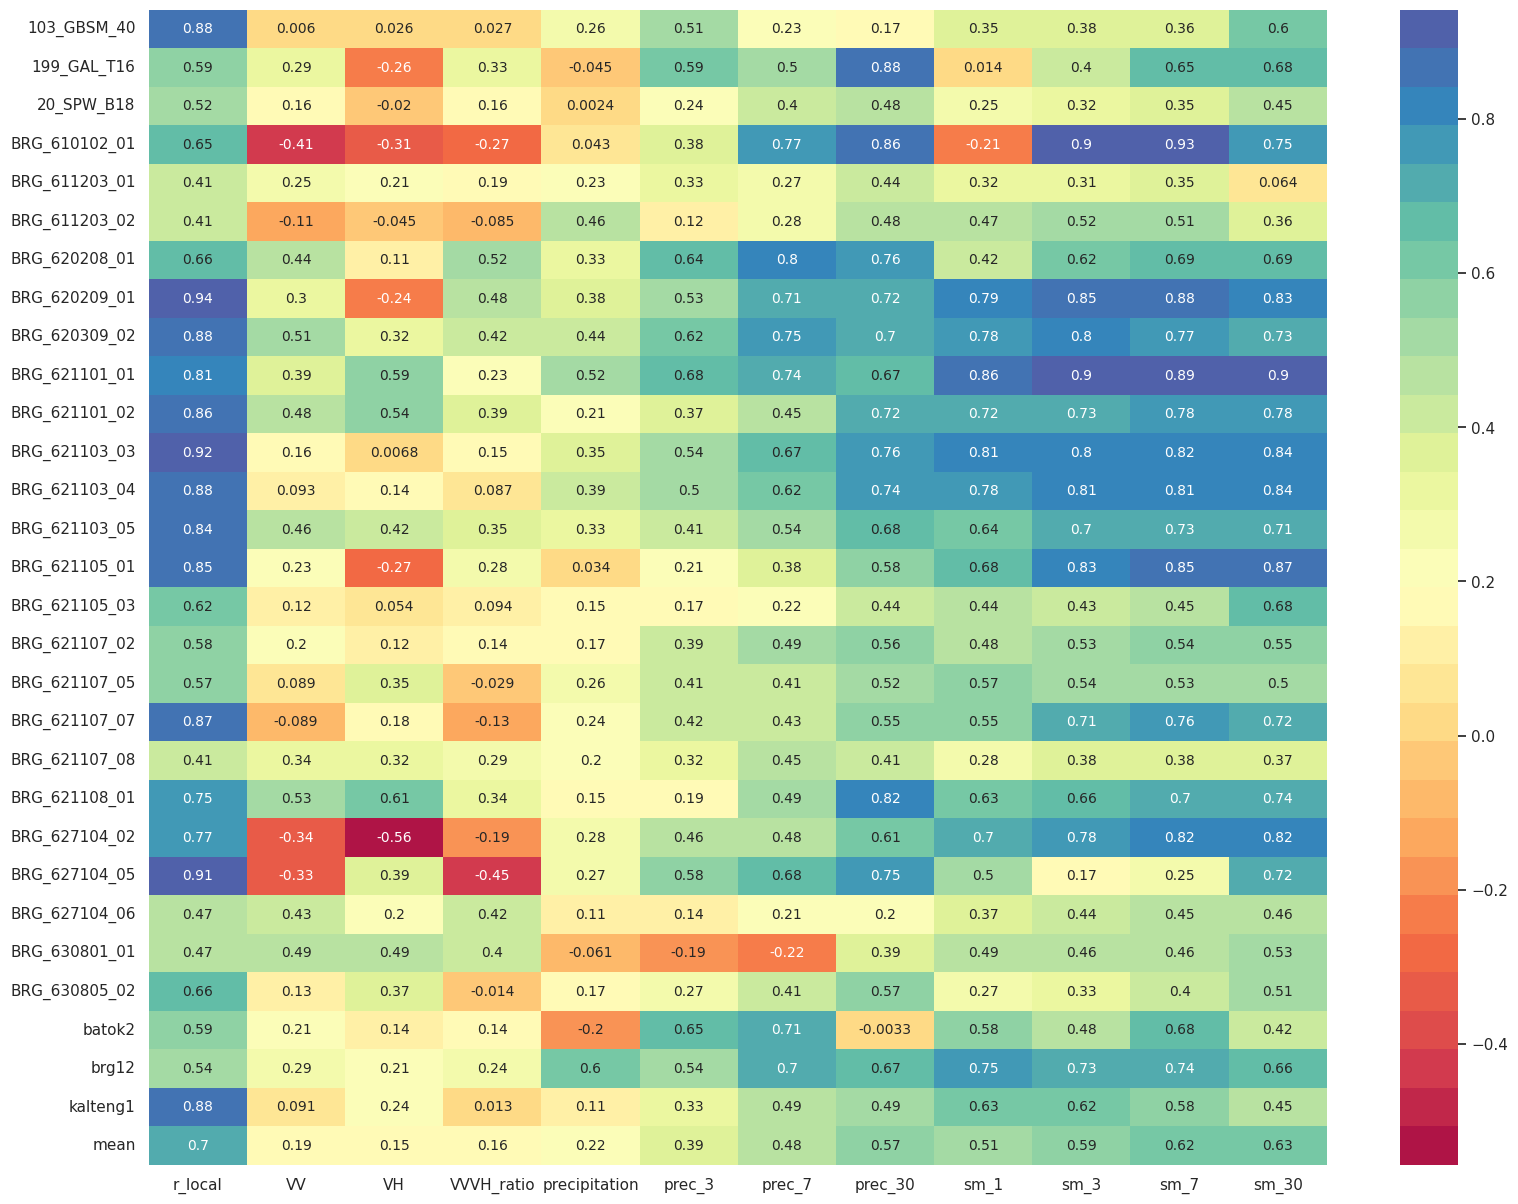

In [22]:
get_heatmap(stats_df, "r_local")

<Axes: title={'center': 'RMSE of stations'}>

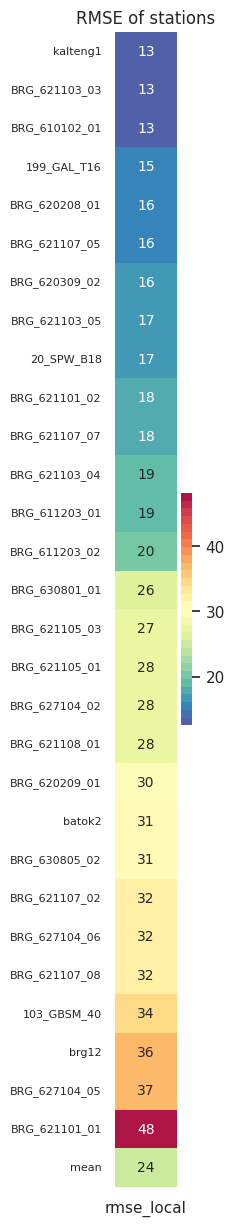

In [23]:
get_heatmap(stats_df, "rmse_local")

In [41]:
best_worse_stations = stats_df[stats_df.rmse_local < 15].index
best_worse_stations

Index(['BRG_610102_01', 'BRG_621103_03', 'kalteng1'], dtype='object')

In [28]:
gdf_high.to_file("data/0_shp/kalimantan_best_stations.gpkg", driver="GPKG")
len(gdf_high)

641

## Final model bootstraping

In [29]:
from gee_scripts.randomforest import bootstrap

In [30]:
bootstrap_stations = list(best_stations) # + list(best_worse_stations)
len(bootstrap_stations)

27

### Bootsrap with only best stations

In [54]:
selected_df = training_df[training_df.id.isin(best_stations)]
bootstrap_result = bootstrap(df = selected_df, variable="gwl_cm", iterations=5, train_size=0.8)
bootstrap_result

,mean,min,max,median
r,0.631807,0.594224,0.692883,0.623891
r2,0.255354,-0.037436,0.461850,0.248823
rmse,11.819441,6.702868,15.082140,13.400036
samples_train,526.000000,487.000000,583.000000,NaN
samples_test,115.000000,58.000000,154.000000,NaN


### Boostrap with best + best worse

In [55]:
selected_df = training_df[training_df.id.isin(list(best_stations) + list(best_worse_stations))]
bootstrap_result = bootstrap(df = selected_df, variable="gwl_cm", iterations=5, train_size=0.8)
bootstrap_result

,mean,min,max,median
r,0.610349,0.361531,0.828991,0.693600
r2,0.246523,-0.231175,0.618789,0.375571
rmse,13.029221,9.387368,19.415474,11.751737
samples_train,553.400000,441.000000,620.000000,NaN
samples_test,160.600000,94.000000,273.000000,NaN


### Boostrap by PHU

In [63]:
selected_df = df[
    (df.phu_id == 136)
]
bootstrap_result = bootstrap(df = selected_df, variable="gwl_cm", iterations=10, train_size=0.8)
bootstrap_result

,mean,min,max,median
r,0.747296,0.471017,0.903195,0.744824
r2,0.452973,-0.019842,0.770691,0.339297
rmse,18.486281,14.234325,24.064455,19.407968
samples_train,287.100000,242.000000,307.000000,NaN
samples_test,59.900000,40.000000,105.000000,NaN


# Bootrsap with BRG

In [71]:
selected_df = df[
    (df.source.isin(["brg", "old_brg"])) & 
    (df.island == "Kalimantan")
]
bootstrap_result = bootstrap(df = selected_df, variable="gwl_cm", iterations=10, train_size=0.8)
bootstrap_result

Training with 1685 observations


,mean,min,max,median
r,0.454731,0.177801,0.622090,0.495782
r2,0.093629,-0.273212,0.331165,0.116760
rmse,22.916410,19.661217,29.129743,21.883502
samples_train,1374.700000,1253.000000,1445.000000,NaN
samples_test,310.300000,240.000000,432.000000,NaN


In [68]:
selected_df = df[
    (df.source.isin(["brg", "old_brg"])) & 
    (df.island != "Sumatera")
]
bootstrap_result = bootstrap(df = selected_df, variable="gwl_cm", iterations=10, train_size=0.8)
bootstrap_result

,mean,min,max,median
r,0.405086,0.226977,0.600478,0.376588
r2,0.024684,-0.294936,0.335683,0.038767
rmse,24.663628,19.137294,29.835556,24.546362
samples_train,1415.200000,1339.000000,1488.000000,NaN
samples_test,317.800000,245.000000,394.000000,NaN


In [ ]:
# # Save model to file with not pickle (pickle is not safe) 
# import joblib
# model_name = "All_but_one_PHU_Kalimantan_high_corr_0_2_temporal_variables"
# joblib.dump(regr, f"data/10_models/{model_name}.joblib")
# plt.savefig(f"{model_name}.png")

In [ ]:
# # open unieqe points geopackage file
# unique_points = gpd.read_file("data/0_shp/unique_stations_no_repeated.shp")

# # export best estations to geopackage
# unique_points[unique_points.id.isin(best_stations)].to_file("data/0_shp/best_kalimantan_corr02_rmse10.gpkg", driver='GPKG')

# # # merge the stats_df with the unique_points
# # unique_points = unique_points.merge(stats_df, left_on='id', right_index=True)

# # # save the unique_points as a geopackage file
# # unique_points.to_file("data/0_shp/kalimantan_r_local.gpkg", driver='GPKG')

In [ ]:
stats_df.sort_values(by="r_local", ascending=False).head(10)